# Appointments Forecast

## Library imports

In [26]:
from os import chdir
from pathlib import Path
import warnings

# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
if "notebooks" in str(Path.cwd()):
    chdir("..")

import os
import numpy as np
import pandas as pd
import joblib
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import PlotCounter, get_workingdays

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Initial set-up

In [27]:
## Constants
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
HISTORICAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region, historical"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "Num_appointments"
USED_APPOINTMENT_COLUMNS = ["SUB_ICB_LOCATION_CODE","APPOINTMENT_MONTH","HCP_TYPE","COUNT_OF_APPOINTMENTS"]
MODEL_FILE_NAME = 'outputs/demographic-month-sklearn.pkl'

# Loading the Data Catalog
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# Set up output directories
for i in ['outputs/assumptions', 'outputs/plots', 'outputs/tables']:
    if not os.path.exists(i):
        os.makedirs(i)

## 1. Loading the Appointments Dataframe

In [28]:
def load_all_areas_gp_appts(catalog_entry_name:str) ->pd.DataFrame:
    catalog_entry = catalog.get_catalog_entry_by_name(catalog_entry_name)
    _ = catalog_entry.load()

    dfs_ = []
    for ccg_name in catalog_entry.zip_file.namelist():
        catalog_entry.csv_file = ccg_name
        dfs_.append(catalog_entry.load())

    combined_df_ = pd.concat(dfs_, axis=0)

    combined_df_ = combined_df_.rename(columns={'CCG_CODE':'SUB_ICB_LOCATION_CODE',
                                                          'Appointment_Month':'APPOINTMENT_MONTH'})
    
    combined_df_ = combined_df_.loc[:,USED_APPOINTMENT_COLUMNS]
    try:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
    except:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'], format='%b-%y')
    
    return combined_df_

latest_gp_appts_df = load_all_areas_gp_appts(REGIONAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = load_all_areas_gp_appts(HISTORICAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = historical_gp_appts_df.loc[~historical_gp_appts_df['APPOINTMENT_MONTH'].isin(latest_gp_appts_df['APPOINTMENT_MONTH'].unique())]
all_area_appts_df = pd.concat([latest_gp_appts_df, historical_gp_appts_df], axis=0)

## 2. EDA

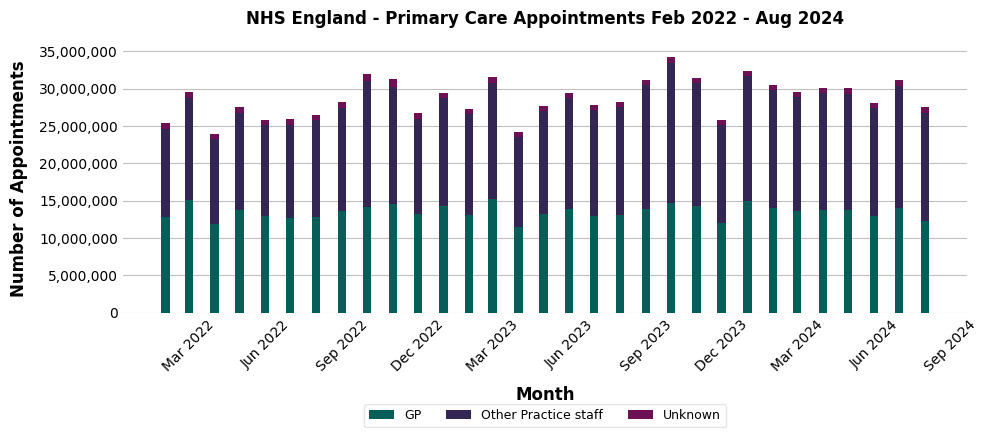

In [29]:
def stacked_bar_appointments(
    df: pd.DataFrame, title: str, ylabel: str, xlabel: str, figsize=(10, 5), color_map=None
):
    fig, ax = plt.subplots(figsize=figsize)

    # Get the unique months and HCP_TYPEs
    months = df["APPOINTMENT_MONTH"].unique()
    hcp_types = df["HCP_TYPE"].unique()

    # Initialize bottoms array for stacking bars
    bottoms = np.zeros(len(months))

    # Iterate over each HCP_TYPE and plot
    for i, hcp_type in enumerate(hcp_types):
        hcp_type_slice = df[df["HCP_TYPE"] == hcp_type].copy()
        ax.bar(
            months,
            hcp_type_slice["COUNT_OF_APPOINTMENTS"].values,
            width=10,
            bottom=bottoms,
            label=hcp_type,
        )
        bottoms += hcp_type_slice["COUNT_OF_APPOINTMENTS"].values

    # Date range for title
    date_range = (
        str([f"{i.strftime('%b %Y')}" for i in [months.min(), months.max()]])[1:-1]
        .replace("'", "")
        .replace(",", " -")
    )

    # Set titles and labels
    ax.set_title(f"{title} {date_range}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    # Ensure y-axis is set to linear scale
    ax.set_yscale('linear')

    # Format y-axis to show actual numbers, adding commas for thousands
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Set x-axis formatting for dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

    # Add legend outside the plot
    ax.legend(bbox_to_anchor=(0.5, -0.45), ncol=3)

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)
    plt.show()


stacked_bar_appointments(
    all_area_appts_df.groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[
        ["COUNT_OF_APPOINTMENTS"]
    ]
    .sum()
    .reset_index(),
    "NHS England - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

- No obvious seasonality

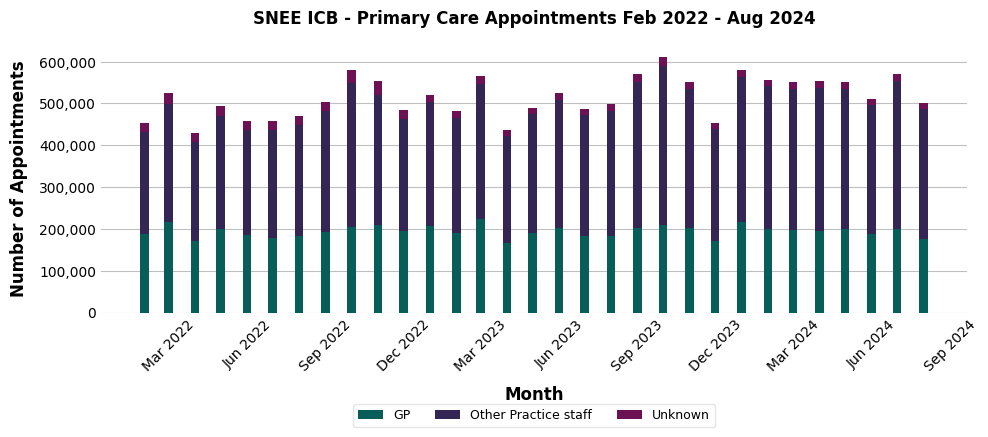

In [30]:
snee_appointments_df = (
    all_area_appts_df.loc[
        all_area_appts_df["SUB_ICB_LOCATION_CODE"].isin(
            list(const.SUB_ICB_CODES.keys())
        )
    ]
    .groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
stacked_bar_appointments(
    snee_appointments_df,
    "SNEE ICB - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

In [31]:
# divide by working days/month to get average appointments per day
monthly_appts_df = snee_appointments_df.groupby('APPOINTMENT_MONTH').sum(numeric_only=True)
monthly_appts_df = monthly_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_appts_df.index))
monthly_appts_df = monthly_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_appts_df['WORKING_DAYS'])
monthly_appts_df.index.freq = 'MS' # set frequency to month start

### 2.1. Check stationarity - overall


In [32]:
# Assume 'data' is your time series data in a pandas Series
result = statsmodels.tsa.stattools.adfuller(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value < 0.05, the data is stationary
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")

ADF Statistic: -3.150267835083833
p-value: 0.023049960507990297
The data is stationary.


### 2.2. For Sub-ICBs

In [33]:
sub_icb_demand_df = all_area_appts_df.groupby(['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH']).sum(numeric_only=True).reset_index().set_index('APPOINTMENT_MONTH')
sub_icb_demand_df = sub_icb_demand_df.assign(WORKING_DAYS=get_workingdays(sub_icb_demand_df.index))
sub_icb_demand_df = sub_icb_demand_df.assign(AVG_APPTS_PER_WORKING_DAY=sub_icb_demand_df['COUNT_OF_APPOINTMENTS'] / sub_icb_demand_df['WORKING_DAYS'])

for sub_icb in const.SUB_ICB_CODES.keys():
    # Assume 'data' is your time series data in a pandas Series
    print(f"SUB_ICB: {const.SUB_ICB_CODES[sub_icb]}")
    result =statsmodels.tsa.stattools.adfuller(sub_icb_demand_df.loc[sub_icb_demand_df['SUB_ICB_LOCATION_CODE']==sub_icb, 'AVG_APPTS_PER_WORKING_DAY'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # If p-value < 0.05, the data is stationary
    if result[1] < 0.05:
        print("The data is stationary.\n")
    else:
        print("The data is not stationary.\n")

SUB_ICB: Ipswich & East Suffolk
ADF Statistic: -3.0219206327885324
p-value: 0.03289738231783997
The data is stationary.

SUB_ICB: West Suffolk
ADF Statistic: -2.553079321975542
p-value: 0.10308766840919553
The data is not stationary.

SUB_ICB: North East Essex
ADF Statistic: -4.020463643687415
p-value: 0.001307067888391801
The data is stationary.



### 2.3. Clear seasonality

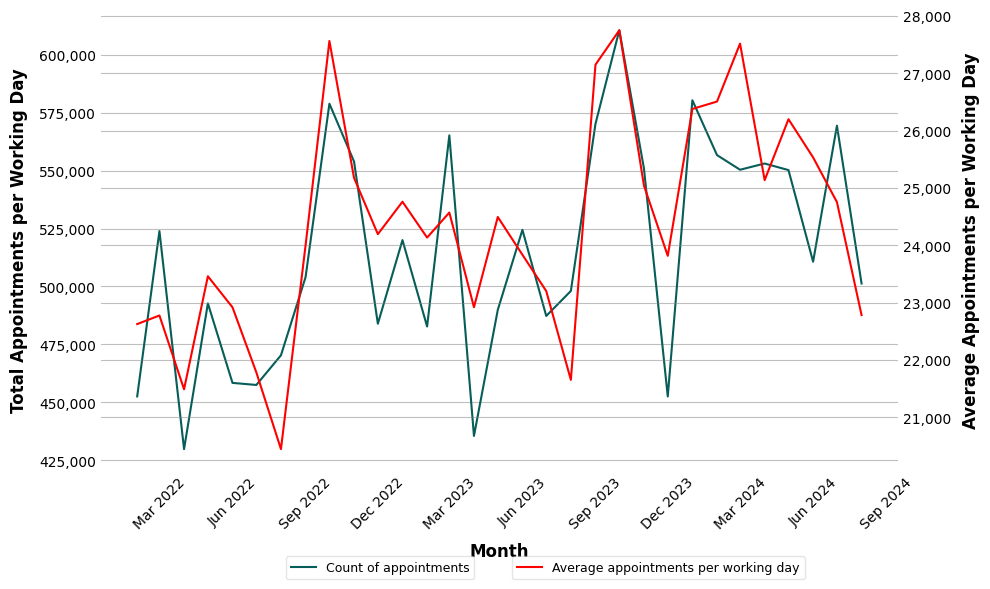

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(monthly_appts_df['COUNT_OF_APPOINTMENTS'], label='Count of appointments')
ax2.plot(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], color='r', label='Average appointments per working day')
ax2.set_ylabel('Average Appointments per Working Day')
ax.set_ylabel('Total Appointments per Working Day')
ax.set_xlabel('Month')
# change x axis format to month, year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.tick_params(axis='x', rotation=45)
ax.legend(bbox_to_anchor=(0.35, -0.25), ncol=1)
ax2.legend(bbox_to_anchor=(0.7, -0.25), ncol=1)
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)
plt.show()

### 2.4. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


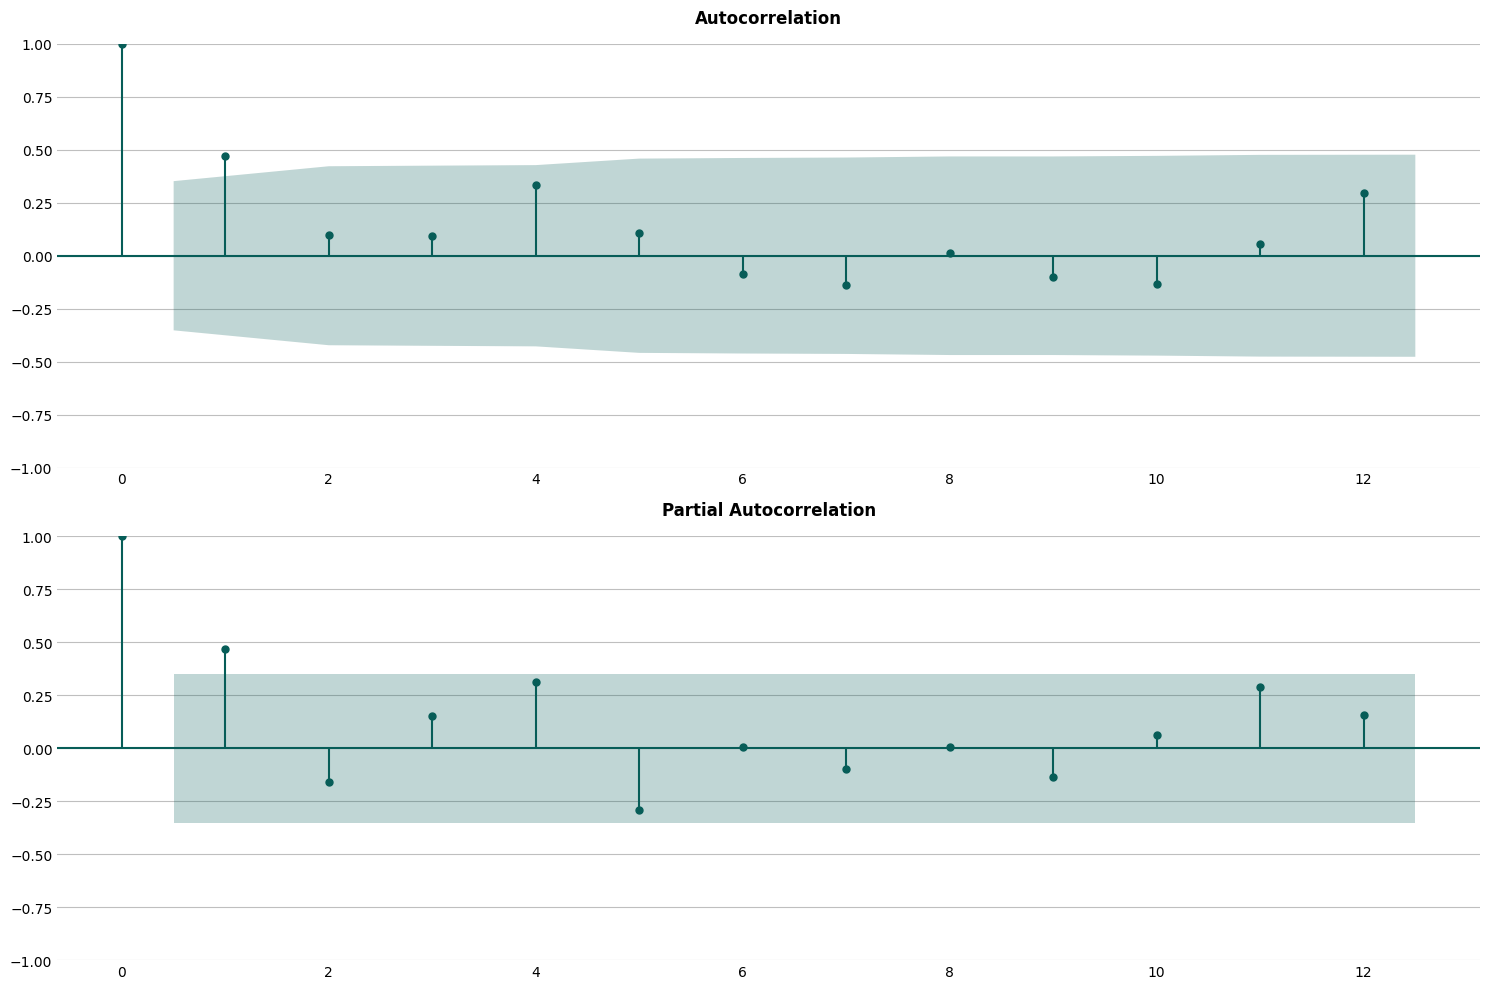

In [35]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[0])
plot_pacf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[1])
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)
plt.show()

### 2.5. Multiply by population

In [36]:
## Multiply by population scenarios to get total appointments
pop_scenarios = {scenario.name: scenario.load() for scenario in catalog.scenario_data_sources[0].scenarios}

pop_scenarios['Principal projection'].loc[pop_scenarios['Principal projection']['AGE_GROUP'] == 'All ages'].head(5)

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
91,E38000004,NHS Barking and Dagenham CCG,Population,persons,All ages,211998.0,213423.294,214681.387,215836.155,216826.434,...,222626.633,223110.809,223618.121,224171.031,224774.823,225392.580,226012.162,226630.010,227249.839,227861.856
183,E38000005,NHS Barnet CCG,Population,persons,All ages,392140.0,395978.585,399641.401,403014.949,406061.106,...,428700.107,430291.496,431862.378,433455.467,435109.164,436755.036,438375.287,439977.126,441569.236,443146.254
275,E38000011,NHS Bexley CCG,Population,persons,All ages,247258.0,248428.446,249590.212,250759.372,251931.170,...,263924.110,264952.556,265991.059,267059.085,268179.631,269308.813,270445.395,271588.236,272739.193,273897.526
367,E38000020,NHS Brent CCG,Population,persons,All ages,330795.0,333311.812,335438.751,337289.458,338873.083,...,350379.684,351371.184,352343.136,353321.358,354293.294,355244.773,356152.099,357011.597,357831.971,358617.807
459,E38000023,NHS Bromley CCG,Population,persons,All ages,331096.0,332838.420,334612.410,336487.631,338249.835,...,353152.406,354187.087,355236.812,356347.166,357570.088,358814.014,360078.016,361367.877,362696.232,364053.536


## 3. Load GP lists data for all areas

In [ ]:
gp_list_df = catalog.get_catalog_entry_by_name("Patients Registered at a GP practice, September 2024").load()

### 3.1. Feature Engineering

#### 3.1.1. Convert population to proportions of population and add 5 year bin

In [39]:
# keep gendered data, and age groups
def convert_gp_list_to_five_year_bins(df: pd.DataFrame) -> pd.Series:
    """
    Converts the GP list dataframe to a new dataframe with age groups grouped into five-year bins.

    Args:
        gp_list_df (pd.DataFrame): The input GP list dataframe.

    Returns:
        pd.DataFrame: The converted dataframe with age groups grouped into five-year bins.
    """

    # Filter the GP list dataframe based on specific conditions
    gp_list_df_ = df.loc[
        (df["ORG_TYPE"] == "SUB_ICB_LOCATION_CODE")
        & (df["SEX"] != "ALL")
        & (df["AGE_GROUP_5"] != "ALL")
    ].copy()

    # Select specific columns from the filtered dataframe
    gp_list_df_ = gp_list_df_.loc[:, ["ORG_CODE", "SEX", "AGE_GROUP_5", "NUMBER_OF_PATIENTS"]]

    # Modify the age group values
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].replace(
        {"90_94": "90+", "95+": "90+"}
    )
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].str.replace("_", "-")

    # Pivot table to get age group as columns
    gp_list_df_ = gp_list_df_.pivot_table(
        index="ORG_CODE", columns="AGE_GROUP_5", values="NUMBER_OF_PATIENTS", aggfunc="sum"
    )
    return gp_list_df_


def convert_5_year_gp_list_to_proportional(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a DataFrame of 5-year GP appointment counts to proportional values.

    Args:
        df (pd.DataFrame): The input DataFrame containing 5-year GP appointment counts.

    Returns:
        pd.DataFrame: The DataFrame with the appointment counts converted to proportional values.
    """
    total_appointments = df.div(df.sum(axis=1), axis=0)
    return total_appointments


# Apply the functions
gp_list_proportional_areas_df = (gp_list_df
                                 .pipe(convert_gp_list_to_five_year_bins)
                                 .pipe(convert_5_year_gp_list_to_proportional))

gp_list_5yr_bins:pd.DataFrame = gp_list_df.pipe(convert_gp_list_to_five_year_bins)

gp_list_area_totals:pd.Series = gp_list_5yr_bins.sum(axis=1)
gp_list_area_totals.name = "NUMBER_OF_PATIENTS"

In [40]:
gp_list_proportional_areas_df.head(5)

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,0.055458,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
00N,0.045284,0.056854,0.054122,0.048466,0.058392,0.070817,0.074586,0.066436,0.057510,0.054047,0.063804,0.071205,0.070699,0.061373,0.050272,0.043822,0.026171,0.016989,0.009151
00P,0.045477,0.055800,0.055959,0.054373,0.065685,0.075099,0.073493,0.065658,0.056461,0.052740,0.064265,0.067396,0.066529,0.058585,0.048917,0.042909,0.025572,0.016439,0.008645
00Q,0.055816,0.072695,0.071172,0.063336,0.068019,0.071145,0.074005,0.071995,0.061097,0.066591,0.063978,0.061669,0.053646,0.043748,0.035688,0.030674,0.018172,0.010962,0.005591
00R,0.045269,0.056524,0.054702,0.050880,0.058145,0.070185,0.072096,0.063817,0.055058,0.054111,0.065934,0.075523,0.071868,0.059076,0.046851,0.045715,0.028382,0.017445,0.008419


In [41]:
gp_list_5yr_bins.head(5)

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,13668,18168,17731,15353,17220,19147,19954,19538,18902,16387,22443,25736,26972,24517,21864,20457,12007,7071,3702
00N,7245,9096,8659,7754,9342,11330,11933,10629,9201,8647,10208,11392,11311,9819,8043,7011,4187,2718,1464
00P,13420,16466,16513,16045,19383,22161,21687,19375,16661,15563,18964,19888,19632,17288,14435,12662,7546,4851,2551
00Q,10443,13601,13316,11850,12726,13311,13846,13470,11431,12459,11970,11538,10037,8185,6677,5739,3400,2051,1046
00R,8125,10145,9818,9132,10436,12597,12940,11454,9882,9712,11834,13555,12899,10603,8409,8205,5094,3131,1511


In [42]:
gp_list_area_totals.head(5)

ORG_CODE
00L    340837
00N    159989
00P    295091
00Q    187096
00R    179482
Name: NUMBER_OF_PATIENTS, dtype: int64

#### 3.1.2. Find total appointments per sub-icb per month with the list size

In [43]:
# total appointments per sub-icb per month with the list size
all_area_appts_df = (
    all_area_appts_df.loc[
        :, ["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH", "COUNT_OF_APPOINTMENTS"]
    ]
    .groupby(["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
all_area_appts_df = (
    all_area_appts_df.set_index("SUB_ICB_LOCATION_CODE")
    .join(gp_list_area_totals)
    .reset_index()
)

all_area_appts_df.head(5)

,index,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,NUMBER_OF_PATIENTS
0,00L,2022-02-01,159752,340837
1,00L,2022-03-01,187108,340837
2,00L,2022-04-01,156186,340837
3,00L,2022-05-01,176738,340837
4,00L,2022-06-01,167637,340837


#### Number of appointments per month per person

(considers the 2023 population only)

In [44]:
# calculate appointments per person per month
all_area_appts_df = all_area_appts_df.assign(
    gp_appts_per_person=lambda df: df["COUNT_OF_APPOINTMENTS"] / df["NUMBER_OF_PATIENTS"]
).drop(columns=["COUNT_OF_APPOINTMENTS", "NUMBER_OF_PATIENTS"])
all_area_appts_df.head(5)

,index,APPOINTMENT_MONTH,gp_appts_per_person
0,00L,2022-02-01,0.468705
1,00L,2022-03-01,0.548966
2,00L,2022-04-01,0.458243
3,00L,2022-05-01,0.518541
4,00L,2022-06-01,0.491839


#### 3.1.3. Add Working days/month
- Calculate appointments per working day
- drop unused columns

In [45]:
# get working days/month
all_area_appts_df["working_days"] = get_workingdays(
    all_area_appts_df["APPOINTMENT_MONTH"].dt
)
# calculate appointments per person per working day
all_area_appts_df["appts_per_person_per_workingday"] = (
    all_area_appts_df["gp_appts_per_person"] / all_area_appts_df["working_days"]
)
# get the month as a number
all_area_appts_df["month"] = all_area_appts_df["APPOINTMENT_MONTH"].dt.month
# drop columns
all_area_appts_df = all_area_appts_df.drop(
    columns=["working_days", "gp_appts_per_person", "APPOINTMENT_MONTH"]
)
all_area_appts_df.head(5)

,index,appts_per_person_per_workingday,month
0,00L,0.023435,2
1,00L,0.023868,3
2,00L,0.022912,4
3,00L,0.024692,5
4,00L,0.024592,6


In [46]:
complete_dataset_df = all_area_appts_df.set_index("index").join(gp_list_proportional_areas_df)
complete_dataset_df

,appts_per_person_per_workingday,month,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
00L,0.023435,2,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,...,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
00L,0.023868,3,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,...,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
00L,0.022912,4,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,...,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
00L,0.024692,5,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,...,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
00L,0.024592,6,0.040101,0.053304,0.052022,0.045045,0.050523,0.056176,0.058544,0.057324,...,0.048079,0.065847,0.075508,0.079135,0.071932,0.064148,0.060020,0.035228,0.020746,0.010861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2C4Y,0.026704,4,0.050476,0.064634,0.062309,0.060937,0.069259,0.071449,0.070931,0.067563,...,0.059323,0.065803,0.065291,0.058380,0.047993,0.041609,0.038751,0.023411,0.014214,0.007349
X2C4Y,0.028138,5,0.050476,0.064634,0.062309,0.060937,0.069259,0.071449,0.070931,0.067563,...,0.059323,0.065803,0.065291,0.058380,0.047993,0.041609,0.038751,0.023411,0.014214,0.007349
X2C4Y,0.027146,6,0.050476,0.064634,0.062309,0.060937,0.069259,0.071449,0.070931,0.067563,...,0.059323,0.065803,0.065291,0.058380,0.047993,0.041609,0.038751,0.023411,0.014214,0.007349
X2C4Y,0.027236,7,0.050476,0.064634,0.062309,0.060937,0.069259,0.071449,0.070931,0.067563,...,0.059323,0.065803,0.065291,0.058380,0.047993,0.041609,0.038751,0.023411,0.014214,0.007349


## 4. Modelling

### 4.1. Preprocessor & Train/Test Split
- PCA for Age columns
- Sin/Cos transformation for Month columns

In [47]:
# Columns for PCA and month transformation
PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44','5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
MONTH_COL = ['month']
TARGET__COL = 'appts_per_person_per_workingday'

# Function to perform sin/cos transformation
def sin_cos_transformer(X):
    angle = 2 * np.pi * X / 12
    sin_component = np.sin(angle)
    cos_component = np.cos(angle)
    return np.column_stack((sin_component, cos_component))

# Sin/Cos transformer using FunctionTransformer
sin_cos_transform = FunctionTransformer(sin_cos_transformer, validate=False)

# Preprocessing pipeline: sin/cos on month and PCA on age 
preprocessor = ColumnTransformer(
    transformers=[
        ('sin_cos', sin_cos_transform, MONTH_COL), 
        ('pca', PCA(), PCA_COLS)
    ],
    remainder='drop'  # Drop other columns, unless needed
)

# Train-test split
train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

# Defining features and target
X_train = train_set.drop(columns=[TARGET__COL])
y_train = train_set[TARGET__COL]

X_test = test_set.drop(columns=[TARGET__COL])
y_test = test_set[TARGET__COL]

### 4.2. Running multiple models and evaluating

In [48]:
# Define the models and their hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'model__fit_intercept': [True, False],
            'model__copy_X': [True, False],
            'model__n_jobs': [None, -1, 1, 2],
            'preprocessor__pca__n_components': [1, 2, 3, 4]  # PCA components as hyperparameter
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10],
            'model__fit_intercept': [True, False],
            'model__max_iter': [1000, 5000],
            'preprocessor__pca__n_components': [1, 2, 3, 4]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10],
            'model__fit_intercept': [True, False],
            'model__solver': ['auto', 'saga'],
            'preprocessor__pca__n_components': [1, 2, 3, 4]
        }
    }
}

# Create a list to store results
results = []

best_model_overall = None
best_rmse = float('inf')

# Iterate through each model
for model_name, model_info in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with the preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    # Set output to 'default' for the pipeline to avoid warnings
    pipeline.set_output(transform='default')

    # Create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        pipeline,
        model_info['params'],
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

    # Predict on the test data
    y_pred = best_model.predict(X_test)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Update best model based on RMSE
    if rmse < best_rmse:
        best_model_overall = best_model

    # Store the results
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'RMSE': rmse,
        'MAE': mae
    })
    
# Convert results to a DataFrame for easier readability
results_df = pd.DataFrame(results)

# Print results for each model
pd.set_option('display.max_colwidth', None)
results_df

Training LinearRegression...
Training Lasso...
Training Ridge...


,Model,Best Params,RMSE,MAE
0,LinearRegression,"{'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': None, 'preprocessor__pca__n_components': 2}",0.001784,0.001479
1,Lasso,"{'model__alpha': 0.01, 'model__fit_intercept': True, 'model__max_iter': 1000, 'preprocessor__pca__n_components': 1}",0.002164,0.001711
2,Ridge,"{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__solver': 'auto', 'preprocessor__pca__n_components': 4}",0.001778,0.001460


### 4.3. Refit the Best model on entire Dataset: make predictions and evaluate

In [49]:
# Refit the model on the entire dataset
def refit_on_full_data(X, y, model):
    model.fit(X, y)
    return model

# # Combine X_train_final and X_test_final to create the full feature set
X_full = complete_dataset_df.drop(columns=[TARGET__COL])

# # Combine y_train and y_test to create the full target set
y_full = complete_dataset_df[TARGET__COL]

# Refit on all data
best_model_overall = refit_on_full_data(X_full, y_full, best_model_overall)

# Predictions on entire data
y_pred = best_model_overall.predict(X_full)

# Evaluation
rmse_lr = root_mean_squared_error(y_full, y_pred)
mae_lr = mean_absolute_error(y_full, y_pred)

print(f'{type(best_model_overall.named_steps['model']).__name__} Model: RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}')

Ridge Model: RMSE: 0.0027, MAE: 0.0021


### 4.4. Visualizations

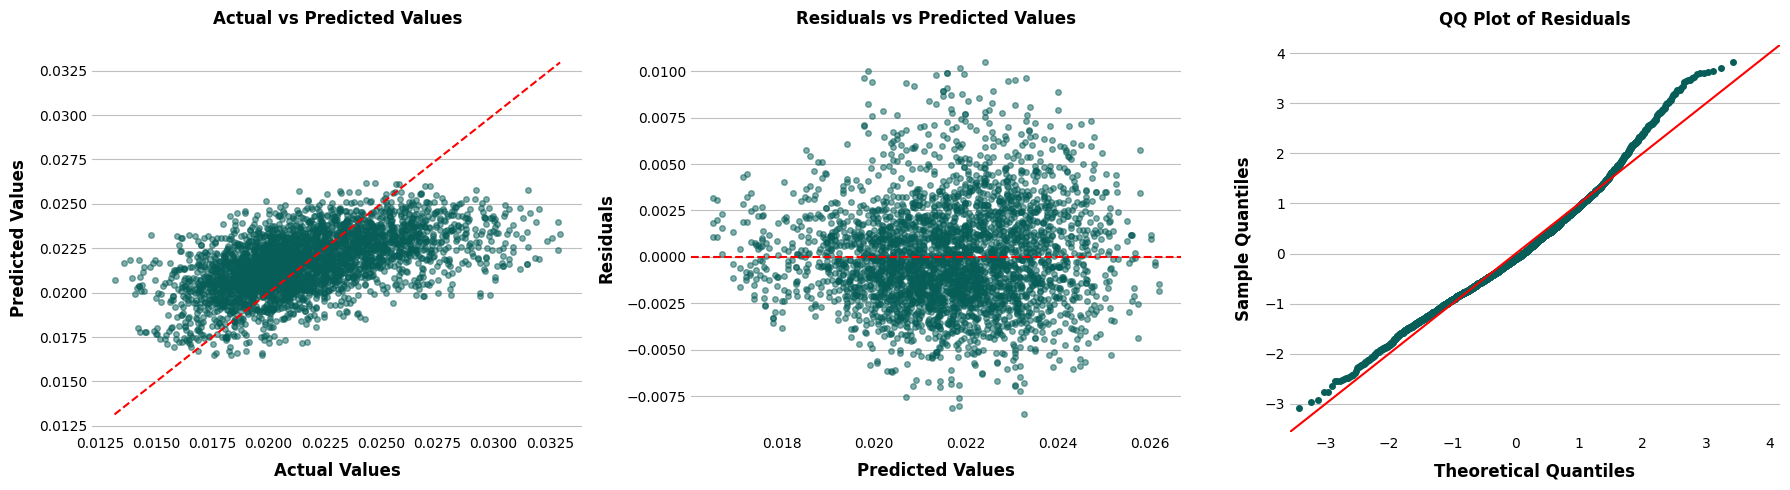

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Actual vs Predicted Values
axs[0].scatter(y_full, y_pred, alpha=0.5)
axs[0].plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], color='red', linestyle='--')
axs[0].set_title('Actual vs Predicted Values')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')

# 2. Residuals vs Predicted Values
residuals = y_full - y_pred
axs[1].scatter(y_pred, residuals, alpha=0.5)
axs[1].axhline(0, color='red', linestyle='--')
axs[1].set_title('Residuals vs Predicted Values')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# 3. QQ Plot for Residuals
sm.qqplot(residuals, line='45', fit=True, ax=axs[2])
axs[2].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)
plt.show()

<b>Actual vs. Predicted Values (Left Plot):</b>
- This plot compares the actual target values to the values predicted by the model.
- The red dashed line represents the ideal scenario where the predicted values exactly match the actual values (i.e., perfect predictions).
- In this case, the points cluster around the line, but there is some spread, indicating that while the model does a decent job predicting, there are noticeable deviations.
- If the spread is consistent across the range, the model may perform well overall but with some errors. <br>
  
<b>Residuals vs. Predicted Values (Middle Plot):</b>
- This plot shows the residuals (the differences between actual and predicted values) against the predicted values.
- The red dashed line at 0 represents where residuals should lie if the model predictions were perfect.
- Ideally, residuals should be randomly scattered around the line, with no discernible pattern. This randomness suggests that the model captures the true relationship well.
- Here, the residuals seem relatively scattered, though there might be some slight variance at different predicted values. This could indicate heteroscedasticity (non-constant variance), meaning that the model's errors might differ across different ranges of predicted values.<br>
  
<b>QQ Plot of Residuals (Right Plot):</b>
- The QQ plot compares the distribution of the residuals to a normal distribution.
- If the residuals are normally distributed, they should lie along the red diagonal line.
- In this case, most points lie along the line, indicating that the residuals are approximately normally distributed. However, there are deviations at the extremes (particularly on the right), suggesting that there might be outliers or that the residuals are slightly skewed.

## 5. Saving the model

In [51]:
# Save the final model using joblib
def save_model(model, filename):
    """
    Save the model to a file using joblib.

    Parameters:
    model : The model object to be saved.
    filename : str, the path and name of the file where the model will be saved.

    Returns:
    None
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")
    

save_model(best_model_overall, MODEL_FILE_NAME)

Model saved to outputs/demographic-month-sklearn.pkl


<b>Overall: The model seems to perform reasonably well but not perfectly. The residuals are generally well-distributed, though there may be slight issues with heteroscedasticity and some outliers or non-normality in the residuals.
The model’s predictions are close but not exact, and there may be some room for improvement in how it handles extreme values or certain ranges of the data. </b>